In [1]:
import pandas as pd

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense,Reshape
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate
import numpy as np
import argparse
import locale
import os
import datetime

import os
import random

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from preprocessing import prepare_stromfluesse,prepare_strompreise,prepare_konsum_ger,enrich_daily_information

---

In [3]:
# Parameter for later testing
# These days should not be seen by the model beforehand
test_number_days = 10

In [4]:
df_stromfluesse = prepare_stromfluesse("data/Stromfluss//")
df_price = prepare_strompreise("data/Strompreise/")
df_consumption = prepare_konsum_ger("data/Stromverbrauch_real/")

Import File: DE_Physikalischer_Stromfluss_201506010000_201706012359_1.csv 
Import File: DE_Physikalischer_Stromfluss_201706020000_201906022359_1.csv 
Import File: DE_Großhandelspreise_201706010000_201906012359_1.csv 
Import File: DE_Großhandelspreise_201506010000_201706012359_1.csv 
Import File: DE_Realisierter Stromverbrauch_201506010000_201706012345_1.csv 
Import File: DE_Realisierter Stromverbrauch_201706010000_201906012345_1.csv 


In [5]:
df_daily_information = enrich_daily_information(df_price,df_consumption)

In [6]:
df = df_stromfluesse.merge(df_daily_information,on="Tag")

# Data

In [7]:
df_prev_day_info = df.loc[:,'prev_day_consumption_ger':'September']
df_prev_day_info.drop_duplicates(inplace=True)
df_prev_day_info['Tag'] = df['Tag']

df['Tag'] = pd.to_datetime(df['Tag'])
df_prev_day_info['Tag'] = pd.to_datetime(df_prev_day_info['Tag'])


In [8]:
df_master = pd.DataFrame(index=np.arange(0,df.Tag.nunique()))
df_master['Tag'] = None
df_master['NX_per_country'] = None

In [9]:
df = df.fillna(0)

In [10]:
ind = 0
for tag,group in df.groupby('Tag'):
    if len(group)==24:
        df_master.loc[ind,'Tag'] =  tag
        df_master.loc[ind,'NX_per_country'] =  group.loc[:,'NL':'PL'].values
    else:
        df_master.loc[ind,'NX_per_country'] = df_master.loc[ind-1,'NX_per_country'] 
        df_master.loc[ind,'Tag'] = df_master.loc[ind-1,'Tag'] 
        print("Tag weniger als 24 EInträge:{} {}".format(tag,len((group))))
    ind +=1

Tag weniger als 24 EInträge:2015-10-25 00:00:00 25
Tag weniger als 24 EInträge:2016-03-27 00:00:00 23
Tag weniger als 24 EInträge:2016-10-30 00:00:00 25
Tag weniger als 24 EInträge:2017-03-26 00:00:00 23
Tag weniger als 24 EInträge:2017-10-29 00:00:00 25
Tag weniger als 24 EInträge:2018-03-25 00:00:00 23
Tag weniger als 24 EInträge:2018-10-28 00:00:00 25
Tag weniger als 24 EInträge:2019-03-31 00:00:00 23


In [11]:
rolling_days = 7
for day in np.arange(1,rolling_days):
    name = 'NX_per_country_shifted_' + str(day)
    df_master[name] = df_master['NX_per_country'].shift(day)

df_master.dropna(inplace=True)

df_master['NX_per_country_aggregated'] = df_master.iloc[:,1::].apply(lambda row: np.concatenate(row), axis=1)

In [12]:
df_master['NX_per_country_shifted'] = df_master['NX_per_country_aggregated'].shift(1)
df_master.dropna(inplace=True)

df_master = df_master[['Tag','NX_per_country','NX_per_country_shifted']]

In [13]:
print(df_master.NX_per_country.iloc[0].shape)
print(df_master.NX_per_country_shifted.iloc[0].shape)
df_master.head()

(24, 9)
(168, 9)


,Tag,NX_per_country,NX_per_country_shifted
7,2015-06-09 00:00:00,"[[3489.0, -1.0, -702.0, -325.0, 0.0, -325.0, 9...","[[3471.0, -304.0, -1130.0, -593.0, 0.0, -291.0..."
8,2015-06-10 00:00:00,"[[3701.0, 154.0, -1661.0, -252.0, 0.0, -256.0,...","[[3489.0, -1.0, -702.0, -325.0, 0.0, -325.0, 9..."
9,2015-06-11 00:00:00,"[[3562.0, 186.0, -1141.0, -325.0, 0.0, -324.0,...","[[3701.0, 154.0, -1661.0, -252.0, 0.0, -256.0,..."
10,2015-06-12 00:00:00,"[[3908.0, 611.0, -1667.0, 37.0, 0.0, -229.0, 1...","[[3562.0, 186.0, -1141.0, -325.0, 0.0, -324.0,..."
11,2015-06-13 00:00:00,"[[3831.0, -245.0, -1134.0, -379.0, 0.0, -210.0...","[[3908.0, 611.0, -1667.0, 37.0, 0.0, -229.0, 1..."


----

In [14]:
df_master['Tag'] = pd.to_datetime(df_master['Tag'])
df_master = df_master.merge(df_prev_day_info,on='Tag')

In [15]:
df_test = df_master.iloc[-1 * test_number_days::]
df_master = df_master.drop(df_master.iloc[-1 * test_number_days::].index)

---

# Models

In [44]:
def create_mlp(dim,layers):
    # define our MLP network
    model = Sequential()
    model.add(Dense(layers[0], input_dim=dim, activation="relu"))
    model.add(Dense(layers[1], activation="relu"))

    return model

In [45]:
def create_cnn(width, height,kernels,dropout_rate ):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    depth=1
    inputShape = (height, width, depth)

    # define the model input
    inputs = Input(shape=inputShape)

    x = inputs
    
    x = Conv2D(kernels[0],kernel_size=(4,1),strides=1, padding="same")(x)
    x = Activation("relu")(x)
    
    x = Dropout(dropout_rate)(x)

    x = Conv2D(kernels[1],kernel_size=(1,width),strides=1, padding="same")(x)
    x = Activation("relu")(x)
    
    
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

---

# Training

In [60]:
# Prepare Data 
df_cnn = df_master[['Tag','NX_per_country_shifted']].copy()
df_mlp = df_master.drop('NX_per_country_shifted',axis=1).copy()

split = train_test_split(df_mlp,df_cnn, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split


testY = testAttrX[['NX_per_country']].copy()
trainY = trainAttrX[['NX_per_country']].copy()

trainAttrX = trainAttrX.drop(['Tag','NX_per_country'],axis=1)
testAttrX = testAttrX.drop(['Tag','NX_per_country'],axis=1)


In [61]:
# Set Architecture Parameter
mlp_layers = [2**6,2**8]
cnn_kernels = [16,32]
cnn_dropout = 0.2

# Set Training Parameter
learning_rate = 1e-3
epochs = 30
batch_size = 5

In [62]:
# Model Architecutre

mlp = create_mlp(trainAttrX.shape[1],mlp_layers)
cnn = create_cnn(9,rolling_days*24,cnn_kernels,cnn_dropout)

combinedInput = concatenate([mlp.output, cnn.output])
x = Dense(2**10)(combinedInput)

x = Dense(24*9,kernel_initializer='normal')(x)
x = Reshape((24, 9))(x)

In [63]:
# Training 

model = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
model.compile(loss="mean_absolute_error", optimizer=opt)

---

In [64]:
# Reshape
trainY = np.array(trainY['NX_per_country'].tolist())
testY = np.array(testY['NX_per_country'].tolist())

trainImagesX = np.expand_dims(np.array(trainImagesX['NX_per_country_shifted'].tolist()), axis=3)
testImagesX = np.expand_dims(np.array(testImagesX['NX_per_country_shifted'].tolist()), axis=3)

In [ ]:
# %%times
# train the model
print("[INFO] training model...")
train_history = model.fit(
    [trainAttrX, trainImagesX], trainY,
    validation_data=([testAttrX, testImagesX], testY),
    epochs=epochs, batch_size=batch_size)

[INFO] training model...
Train on 1083 samples, validate on 361 samples
Epoch 1/30
1083/1083 [==============================] - 169s 157ms/step - loss: 1359.4501 - val_loss: 734.1682
Epoch 2/30
1083/1083 [==============================] - 159s 147ms/step - loss: 826.2743 - val_loss: 651.6814
Epoch 3/30
1083/1083 [==============================] - 155s 143ms/step - loss: 513.1294 - val_loss: 666.2439
Epoch 4/30
1083/1083 [==============================] - 155s 143ms/step - loss: 505.9854 - val_loss: 597.0974
Epoch 5/30
1083/1083 [==============================] - 9901s 9s/step - loss: 415.8039 - val_loss: 582.7038
Epoch 6/30
1083/1083 [==============================] - 157s 145ms/step - loss: 393.8442 - val_loss: 594.4417
Epoch 7/30
1083/1083 [==============================] - 160s 148ms/step - loss: 375.7725 - val_loss: 626.6974
Epoch 8/30
1083/1083 [==============================] - 166s 153ms/step - loss: 358.0819 - val_loss: 673.6258
Epoch 9/30
1083/1083 [===========================

---

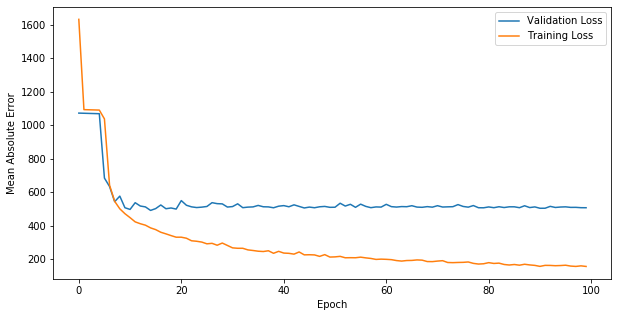

In [639]:
plt.figure(figsize=[10,5])
index = np.arange(0,len(train_history.history['val_loss']))

plt.plot(index,train_history.history['val_loss'])
plt.plot(index,train_history.history['loss'])
plt.legend(['Validation Loss', 'Training Loss'])
plt.ylabel("Mean Absolute Error")
plt.xlabel("Epoch")

plt.show()

In [640]:
model_id = random.randint(0,9999999)
path = "model/" + str(model_id)
os.mkdir(path)

file = open(path + "/model_parameters.txt","a") 
file.write("Type: {}\n".format("CNN + MLP")) 
file.write("CNN Dimensions {}-{}\n".format(cnn_kernels,cnn_dropout)) 
file.write("MLP Dimensions {}\n".format(mlp_layers)) 

file.write("Learning Rate: {}\n".format(learning_rate)) 
file.write("Epochs: {}\n".format(epochs)) 
file.write("Batch Size: {}\n".format(batch_size)) 
file.write("Loss: {}\n".format(train_history.history['loss'])) 
file.write("Validation Loss: {}\n".format(train_history.history['val_loss']))
file.write("Final Validation Loss: {}".format(train_history.history['val_loss'][-1])) 

file.close() 


model.save(path+"/model_weights.hdf5")
model_json = model.to_json()
with open(path+"/model.json", "w") as json_file:
    json_file.write(model_json)


---

---

# Predict on Test Data

In [641]:
test_attrX_time = df_master.iloc[-1 * test_number_days::][testAttrX.columns]
test_imageX_time = df_master.iloc[-1 * test_number_days::][['Tag','NX_per_country_shifted']]
test_imageX_time = np.expand_dims(np.array(test_imageX_time['NX_per_country_shifted'].tolist()), axis=3)

In [642]:
preds = model.predict([test_attrX_time, test_imageX_time])

In [643]:
df_predictions = pd.DataFrame(columns=df.columns[2:12])
df_true_test_values = pd.DataFrame(columns=df.columns[2:12])

### Predictions

In [644]:
test_index = df_master.iloc[-1 * test_number_days::][['Tag']].reset_index(drop=True)
ind = 0 


for pred in preds:
    data = pd.DataFrame(data=pred,columns=df.columns[3:12])
    data['Tag'] = test_index['Tag'][ind] + np.arange(24) * datetime.timedelta(hours=1)

    if ind==0:
        df_predictions = data
    else:
        df_predictions = df_predictions.append(data)
    
    ind+=1

### Ground Truth

In [645]:
test_index = df_master.iloc[-1 * test_number_days::][['Tag']].reset_index(drop=True)
ind = 0 


for test in np.array(df_master.iloc[-1*test_number_days::]['NX_per_country'].tolist()):
    
    data = pd.DataFrame(data=test,columns=df.columns[3:12])
    
    data['Tag'] = test_index['Tag'][ind] + np.arange(24) * datetime.timedelta(hours=1)

    if ind==0:
        df_true_test_values = data
    else:
        df_true_test_values = df_true_test_values.append(data)
    
    ind+=1

---

## Compare Results

In [646]:
df_predictions = df_predictions.reset_index(drop=True)
df_true_test_values = df_true_test_values.reset_index(drop=True)

<Figure size 1440x720 with 0 Axes>

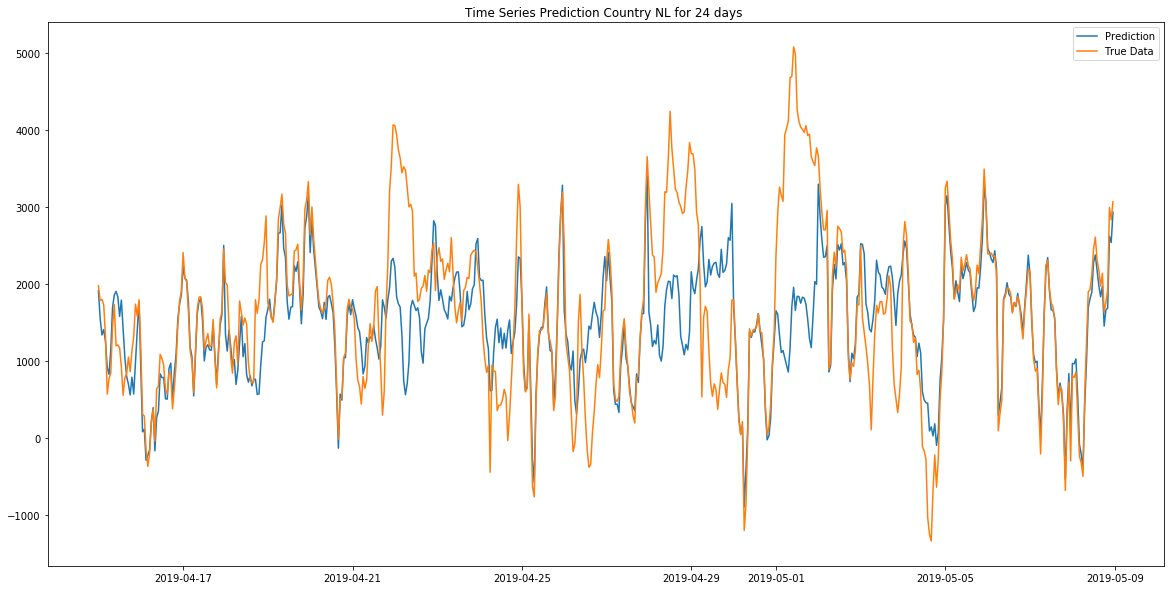

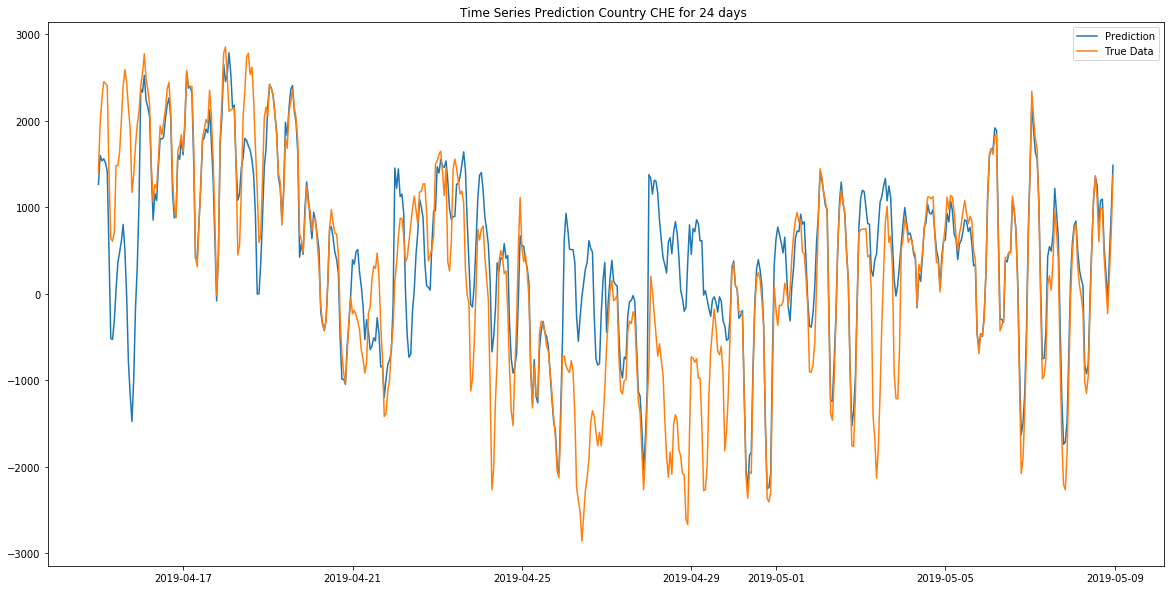

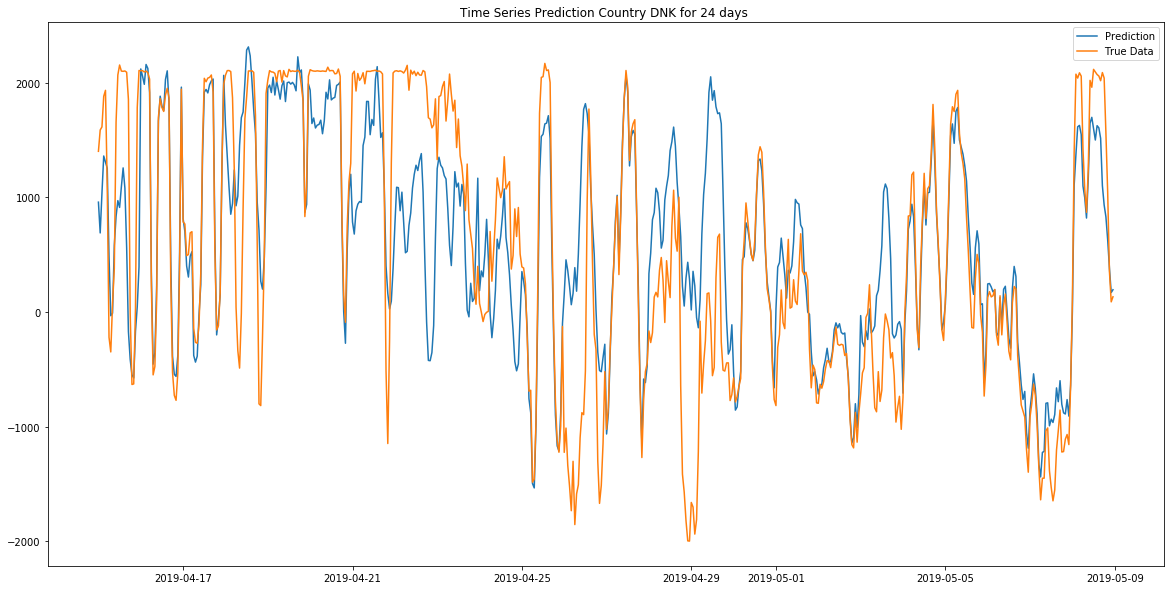

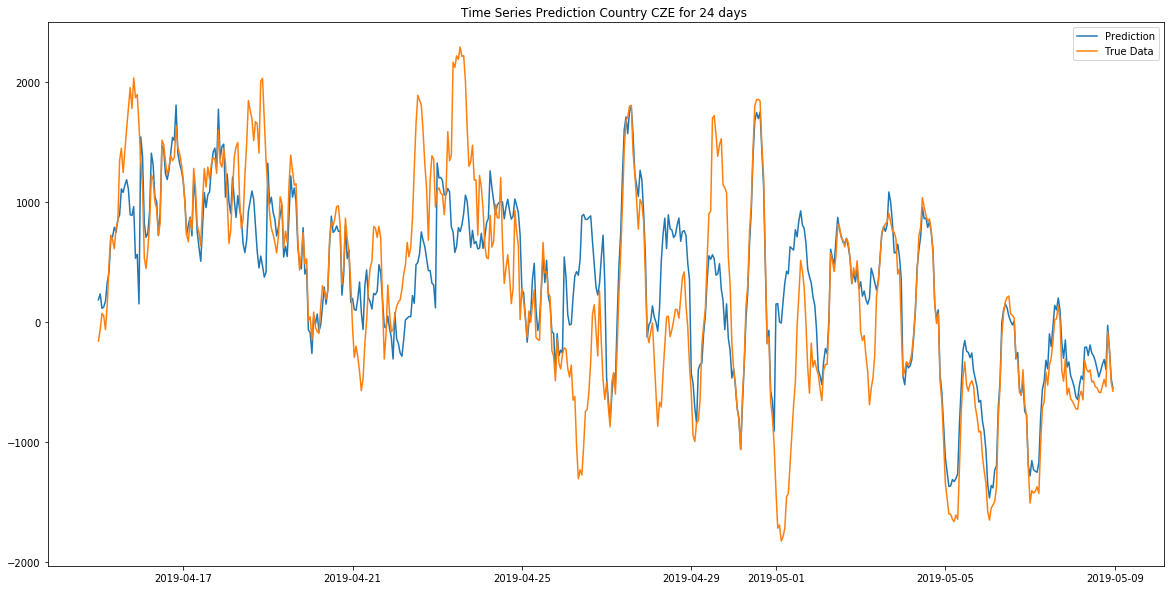

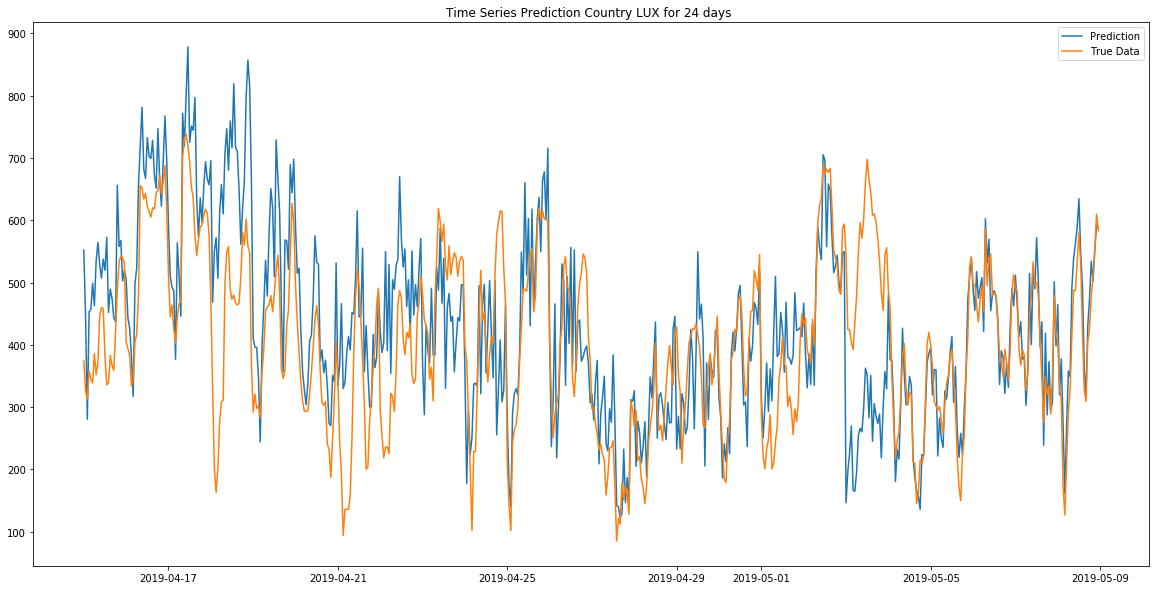

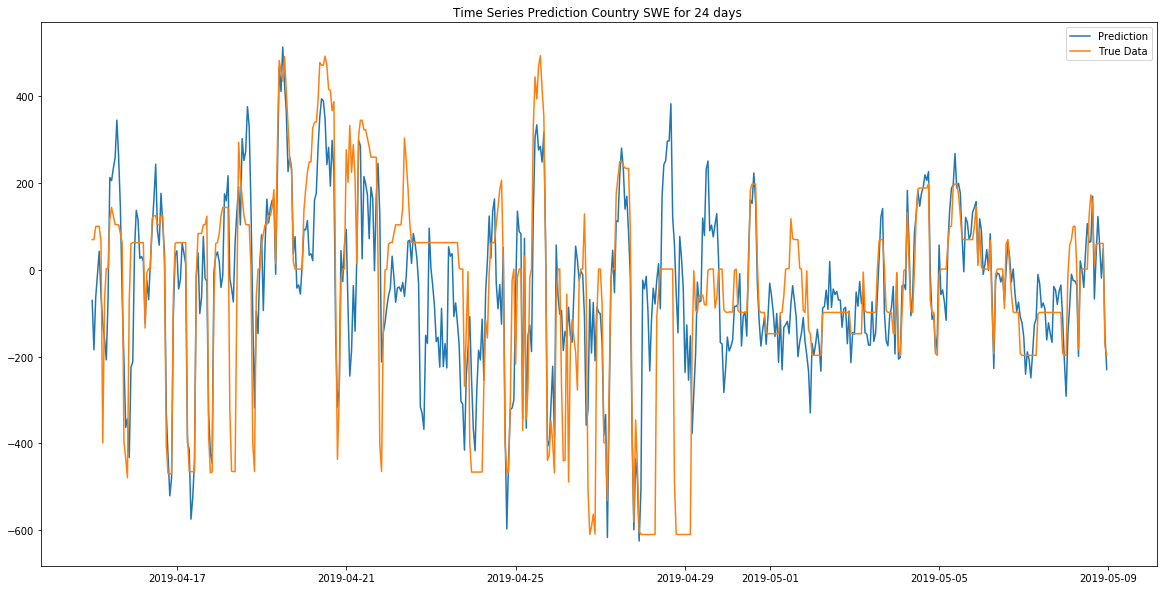

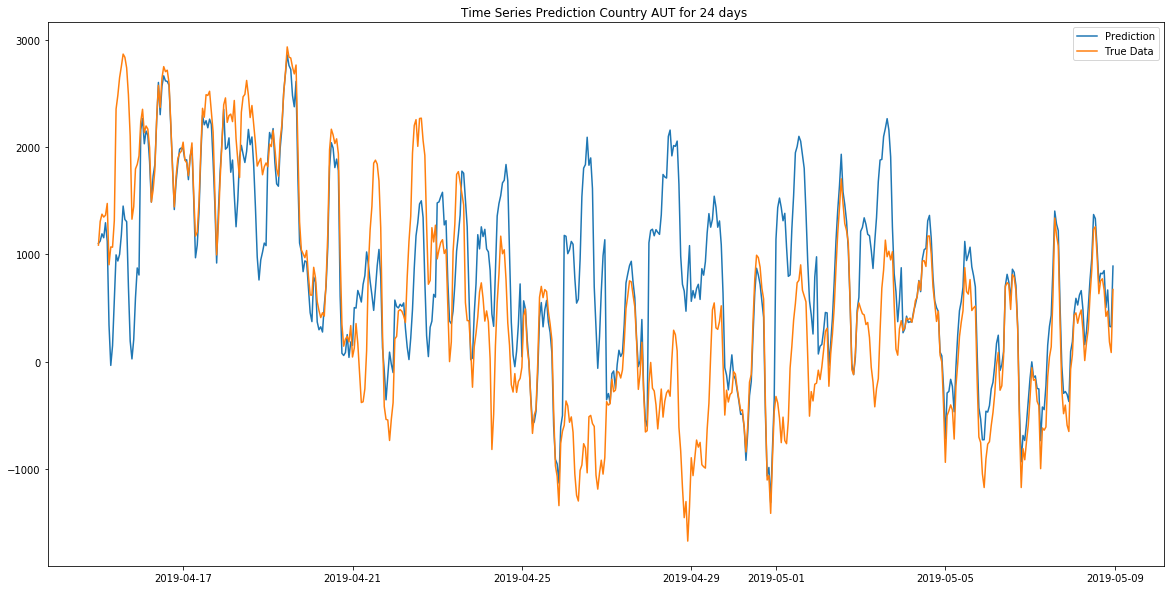

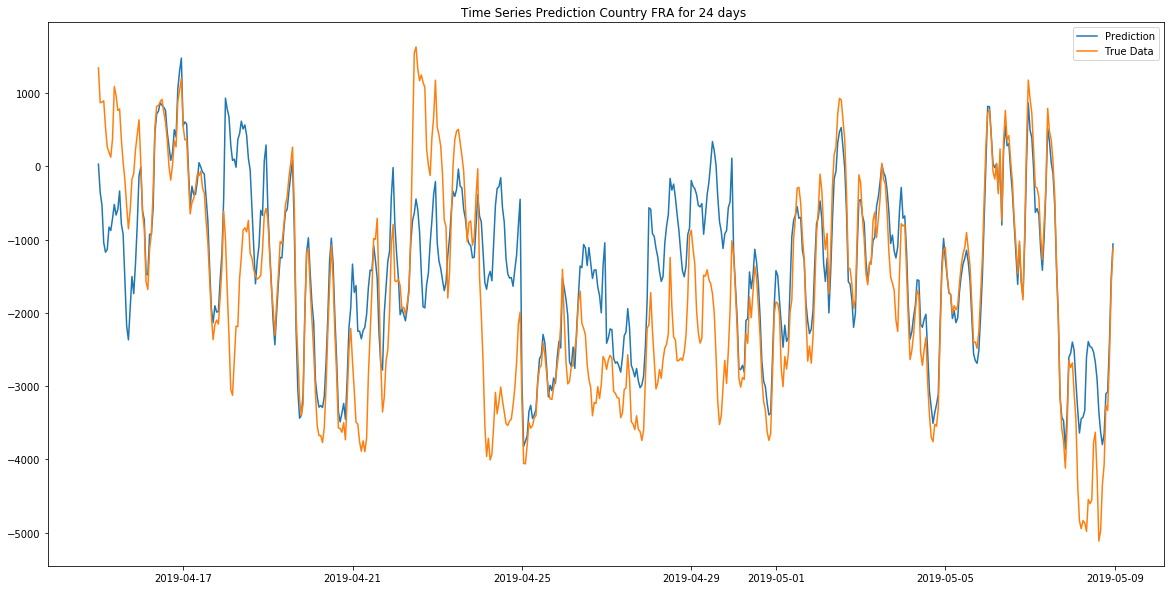

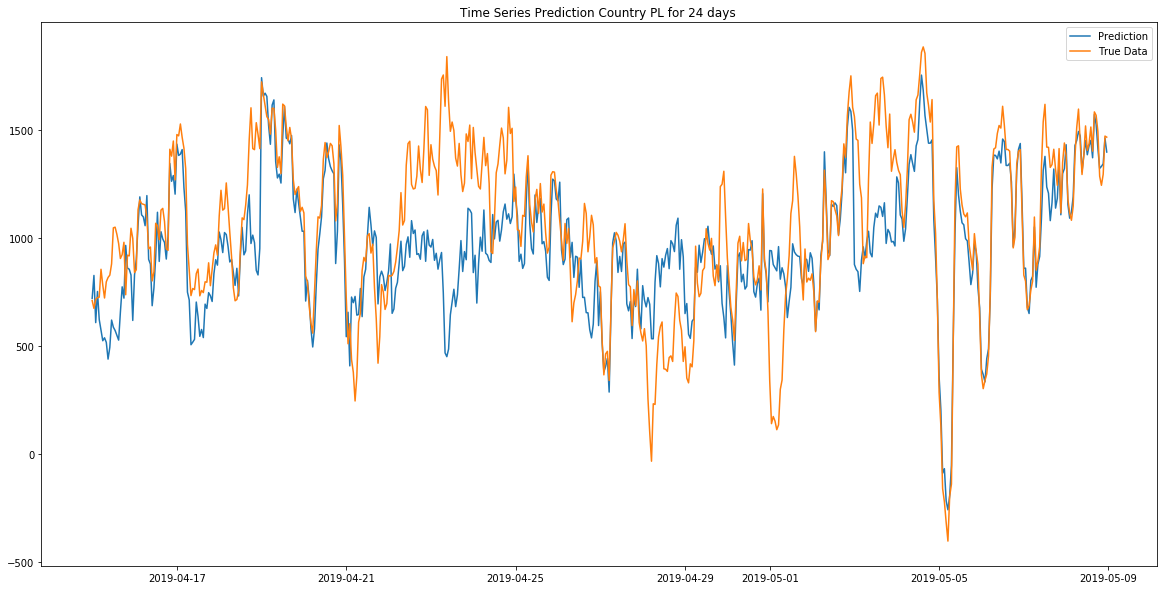

In [647]:
plt.figure(figsize=[20,10])

for col in df_predictions.columns[:9]:
    plt.figure(figsize=[20,10])
    plt.plot(df_predictions['Tag'],df_predictions[col])
    plt.plot(df_true_test_values['Tag'],df_true_test_values[col])
    plt.title("Time Series Prediction Country {} for {} days ".format(col,test_number_days))
    plt.legend(['Prediction','True Data'])
    plt.show()

---